## EDA based in RQs

### Business Question: To what extent can we predict a movie’s revenue based on its genre, budget level, and time of release, and which combinations of these factors are most profitable for studios?

Sub-questions:

1. How does a movie’s genre influence its revenue performance, and which genres tend to generate the highest returns? [Genre effect]
2. How do high-budget and low-budget films differ in their revenue outcomes, and which budget category achieves higher return-on-investment (ROI) within each genre? [Budget level effect]
3. How does the time of release (season, month, or quarter) impact movie revenue, and which release periods consistently outperform others?[Timing effect]
4. Can we accurately predict movie revenue using a machine learning model that incorporates genre, budget level, and release timing as key predictors? [Predictive model] 

In [1]:
# Code Benita
import numpy as np
import pandas as pd
from plotnine import *  # Import everything for visualization
import os
import scipy
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # Print all outputs
from IPython.core.display import HTML  # Pretty print DataFrames
import seaborn as sns  # For correlation heatmap
import matplotlib.pyplot as plt  # For displaying heatmap
import re  # Added import for regular expressions
import pickle #for caching

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Get current working directory
os.getcwd()

'c:\\Users\\arian\\OneDrive\\Desktop\\AI\\Assignment Material'

In [4]:
# ============================================================
# CONFIGURATION
# ============================================================
CACHE_FOLDER = r"C:\Users\arian\Documents\cache_folder"
USE_CACHE = True

FILE_PATHS = {
    "sales_df": r"sales.xlsx",
    "meta_df": r"metaClean43Brightspace.xlsx"
}

# ============================================================
# CACHE MANAGEMENT FUNCTIONS
# ============================================================
def create_cache_folder():
    """Create cache folder if it doesn't exist on the file system"""
    if not os.path.exists(CACHE_FOLDER):
        os.makedirs(CACHE_FOLDER)
        print(f"Created cache folder: {CACHE_FOLDER}")

def get_cache_path(filename):
    """Generate full file path for cached pickle file"""
    return os.path.join(CACHE_FOLDER, f"{filename}.pkl")

def save_to_cache(data, filename):
    """Save dataframe or data object to cache file using pickle serialization"""
    try:
        create_cache_folder()
        cache_path = get_cache_path(filename)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  ✓ Cached {filename}")
    except Exception as e:
        print(f"  ⚠ Could not cache {filename}: {e}")

def load_from_cache(filename):
    """Load dataframe or data object from cache file if it exists"""
    try:
        cache_path = get_cache_path(filename)
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                data = pickle.load(f)
            print(f"  ✓ Loaded {filename} from cache")
            return data
        else:
            return None
    except Exception as e:
        print(f"  ⚠ Could not load {filename} from cache: {e}")
        return None


In [5]:
# ============================================================
# DATA LOADING
# ============================================================
def load_single_dataset(dataset_name, file_path):
    """Load a single dataset from cache or Excel file"""
    print(f"\nLoading {dataset_name}...")
    if USE_CACHE:
        cached_data = load_from_cache(dataset_name)
        if cached_data is not None:
            return cached_data

    try:
        print(f"  Loading from Excel: {file_path}")
        data = pd.read_excel(file_path)
        if USE_CACHE:
            save_to_cache(data, dataset_name)
        print(f"  ✓ Loaded {dataset_name} from Excel ({len(data)} rows)")
        return data
    except FileNotFoundError as e:
        print(f"  ✗ Error loading {dataset_name}: {e}")
        print("  Please check that the file path is correct")
        raise

def load_all_datasets():
    """Load only sales_df and meta_file_clean datasets"""
    print("Loading datasets...")
    datasets = {}
    for dataset_name, file_path in FILE_PATHS.items():
        datasets[dataset_name] = load_single_dataset(dataset_name, file_path)

    print("\nAll files loaded successfully!")
    for name, df in datasets.items():
        print(f"\n{name} columns:")
        print(df.columns.tolist())
        print(f"Shape: {df.shape}")
    return datasets

# ============================================================
# TITLE / NAME CLEANING HELPER
# ============================================================
def clean_movie_name(text):
    """
    Aggressive cleaning for generating stable keys / IDs.
    - Lowercase
    - Strip URL path / punctuation
    - Remove brackets & years
    - Collapse spaces
    """
    if pd.isna(text) or text is None:
        return ""
    name = str(text).lower().strip().rstrip("/")

    # If it's a URL, just use the last segment after '/'
    name = name.rsplit("/", 1)[-1]

    # Replace dashes/underscores with spaces
    name = name.replace("-", " ").replace("_", " ")

    # Remove bracketed content () or []
    name = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", name)

    # Remove non-alphanumeric (keep spaces)
    name = re.sub(r"[^a-z0-9 ]", "", name)

    # Remove trailing years like "1999" or "2016"
    name = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", name)

    # Collapse multiple spaces
    name = re.sub(r"\s+", " ", name).strip()

    return name

# ============================================================
# CREATE cleaned_title FOR EACH DATASET
# ============================================================
def create_cleaned_title_for_sales(sales_df):
    """
    Ensure sales_df has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'url'
    - Else fall back to 'Title'/'title'
    - Else mark as empty
    """
    if "cleaned_title" in sales_df.columns:
        print("sales_df: 'cleaned_title' already exists, reusing.")
        return

    if "url" in sales_df.columns:
        source_col = "url"
        print("sales_df: creating 'cleaned_title' from 'url'")
    elif "Title" in sales_df.columns:
        source_col = "Title"
        print("sales_df: creating 'cleaned_title' from 'Title'")
    elif "title" in sales_df.columns:
        source_col = "title"
        print("sales_df: creating 'cleaned_title' from 'title'")
    else:
        print("sales_df: no suitable title-like column found, setting empty cleaned_title")
        sales_df["cleaned_title"] = ""
        return

    sales_df["cleaned_title"] = sales_df[source_col].apply(clean_movie_name)

def create_cleaned_title_for_meta(meta_df):
    """
    Ensure meta_file_clean has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'Title'/'title'
    - Else fall back to 'url'
    - Else mark as empty
    """
    if "cleaned_title" in meta_df.columns:
        print("meta_file_clean: 'cleaned_title' already exists, reusing.")
        return

    if "Title" in meta_df.columns:
        source_col = "Title"
        print("meta_file_clean: creating 'cleaned_title' from 'Title'")
    elif "title" in meta_df.columns:
        source_col = "title"
        print("meta_file_clean: creating 'cleaned_title' from 'title'")
    elif "url" in meta_df.columns:
        source_col = "url"
        print("meta_file_clean: creating 'cleaned_title' from 'url'")
    else:
        print("meta_file_clean: no suitable title-like column found, setting empty cleaned_title")
        meta_df["cleaned_title"] = ""
        return

    meta_df["cleaned_title"] = meta_df[source_col].apply(clean_movie_name)

# ============================================================
# MOVIE ID GENERATION BASED ON cleaned_title
# ============================================================
def create_movie_ids_for_meta_and_sales(datasets_dict):
    """
    Create stable movie_id values based ONLY on a single standardized 'cleaned_title'
    shared between meta_file_clean and sales_df.

    - cleaned_title is the canonical movie name (lowercase, stripped)
    - movie_id is generated from unique cleaned_title across both datasets
    - Any raw 'Title' / 'title' columns are left alone here but can be dropped later
    """
    sales_df = datasets_dict["sales_df"]
    meta_df = datasets_dict["meta_df"]

    # Build cleaned_title in both datasets
    create_cleaned_title_for_sales(sales_df)
    create_cleaned_title_for_meta(meta_df)

    # Collect all cleaned titles from both
    all_cleaned = pd.concat([
        sales_df["cleaned_title"].dropna(),
        meta_df["cleaned_title"].dropna()
    ]).unique()

    # Filter out empty strings
    all_cleaned = [t for t in all_cleaned if isinstance(t, str) and t.strip() != ""]

    # Create movie_key dimension: movie_id ↔ cleaned_title
    movie_key = pd.DataFrame([
        {
            "movie_id": idx + 1,
            "cleaned_title": cleaned
        }
        for idx, cleaned in enumerate(sorted(all_cleaned))
    ])

    print(f"\nCreated movie_key with {len(movie_key)} unique movies")

    # Map cleaned_title -> movie_id
    name_to_id = dict(zip(movie_key["cleaned_title"], movie_key["movie_id"]))

    # Attach movie_id back to both dataframes
    sales_df["movie_id"] = sales_df["cleaned_title"].map(name_to_id).astype("Int64")
    meta_df["movie_id"] = meta_df["cleaned_title"].map(name_to_id).astype("Int64")

    # Optional: drop any raw Title columns if you want *only* cleaned_title going forward
    for df_name, df in [("sales_df", sales_df), ("meta_file_clean", meta_df)]:
        raw_title_cols = [c for c in df.columns if c.lower() == "title"]
        if raw_title_cols:
            df.drop(columns=raw_title_cols, inplace=True)
            print(f"{df_name}: dropped raw title columns {raw_title_cols}")

    return movie_key, sales_df, meta_df

# ============================================================
# MERGE META + SALES ON movie_id (KEEP ONLY cleaned_title)
# ============================================================
def merge_meta_and_sales_on_movie_id(meta_df, sales_df):
    merged = meta_df.merge(
        sales_df,
        on="movie_id",
        how="inner",
        suffixes=("_meta", "_sales")
    )
    print(f"\nMerged meta_file_clean + sales_df on movie_id: {merged.shape[0]} rows")

    # unify cleaned_title
    if "cleaned_title_meta" in merged.columns and "cleaned_title_sales" in merged.columns:
        merged["cleaned_title"] = merged["cleaned_title_meta"]
        merged.drop(columns=["cleaned_title_meta", "cleaned_title_sales"], inplace=True)
        print("Merged: unified 'cleaned_title' column.")

    # Drop rows where movie_id was not assigned
    before = merged.shape[0]
    merged = merged[merged["movie_id"].notna()].copy()
    after = merged.shape[0]
    print(f"Dropped {before - after} rows due to missing movie_id")

    return merged


# ============================================================
# EXAMPLE USAGE
# ============================================================
if __name__ == "__main__":
    # 1) Load only meta & sales
    datasets = load_all_datasets()
    sales_df = datasets["sales_df"]
    meta_file_clean = datasets["meta_df"]

    # 2) Create standardized cleaned_title + movie_id
    movie_key, sales_df, meta_df = create_movie_ids_for_meta_and_sales(datasets)

    # 3) Merge on movie_id with a single cleaned_title column
    merged_df = merge_meta_and_sales_on_movie_id(meta_file_clean, sales_df)

    # 4) Quick sanity checks
    print("\n=== merged_df HEAD (movie_id, cleaned_title) ===")
    print(merged_df[["movie_id", "cleaned_title"]].head())

    print("\n=== movie_key HEAD ===")
    print(movie_key.head())


Loading datasets...

Loading sales_df...
  ✓ Loaded sales_df from cache

Loading meta_df...
  ✓ Loaded meta_df from cache

All files loaded successfully!

sales_df columns:
['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime', 'keywords', 'creative_type', 'url']
Shape: (30612, 16)

meta_df columns:
['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards', 'metascore', 'userscore', 'RelDate']
Shape: (11364, 13)
sales_df: creating 'cleaned_title' from 'url'
meta_file_clean: creating 'cleaned_title' from 'title'

Created movie_key with 34259 unique movies
sales_df: dropped raw title columns ['title']
meta_file_clean: dropped raw title columns ['title']

Merged meta_file_clean + sales_df on movie_id: 7676 rows
Merged: unified 'cleaned_title' column.
Dropped 209 rows due to missing mov

In [6]:
# Display shapes and heads to verify loading
sales_df.shape
sales_df.head()
meta_df.shape
meta_df.head()

# Data types and info
sales_df.info()
meta_df.info()

# Check for missing values
sales_missing = sales_df.isnull().sum()
sales_missing[sales_missing > 0]
meta_missing = meta_df.isnull().sum()
meta_missing[meta_missing > 0]

(30612, 17)

,year,release_date,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url,cleaned_title,movie_id
0,2000,January 1st,Drama,76576.0,NaN,76576.0,NaN,NaN,NaN,NaN,NaN,129.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Bakha-Satang...,bakha satang,2936
1,2001,January 12th,Thriller/Suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,2433.0,3.1,NaN,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Antitrust,antitrust,2058
2,2000,January 28th,NaN,NaN,378562.0,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,https://www.the-numbers.com/movie/Santitos,santitos,25100
3,2002,2002 (Wide) by,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.the-numbers.com/movie/Frank-McKlus...,frank mcklusky c i,10414
4,2002,January 25th,Drama,4833792.0,41227069.0,46060861.0,11000000.0,NaN,12177488.0,2411.0,5.3,NaN,Coming of Age,Contemporary Fiction,https://www.the-numbers.com/movie/Walk-to-Reme...,walk to remember a,32475


(11364, 14)

,url,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate,cleaned_title,movie_id
0,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01,women art revolution,33310
1,https://www.metacritic.com/movie/10-cloverfiel...,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11,10 cloverfield lane,10
2,https://www.metacritic.com/movie/10-items-or-less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01,10 items or less,16
3,https://www.metacritic.com/movie/10-years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14,10 years,25
4,https://www.metacritic.com/movie/100-bloody-acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28,100 bloody acres,29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30612 entries, 0 to 30611
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      30612 non-null  int64  
 1   release_date              30612 non-null  object 
 2   genre                     28908 non-null  object 
 3   international_box_office  21575 non-null  float64
 4   domestic_box_office       11884 non-null  float64
 5   worldwide_box_office      21575 non-null  float64
 6   production_budget         4480 non-null   float64
 7   Unnamed: 8                0 non-null      float64
 8   opening_weekend           10929 non-null  float64
 9   theatre_count             10963 non-null  float64
 10  avg run per theatre       10952 non-null  float64
 11  runtime                   24559 non-null  float64
 12  keywords                  12517 non-null  object 
 13  creative_type             26667 non-null  object 
 14  url   

genre                        1704
international_box_office     9037
domestic_box_office         18728
worldwide_box_office         9037
production_budget           26132
Unnamed: 8                  30612
opening_weekend             19683
theatre_count               19649
avg run per theatre         19660
runtime                      6053
keywords                    18095
creative_type                3945
movie_id                       19
dtype: int64

studio        350
rating       1067
runtime       255
cast         3702
director       14
genre          20
summary      5897
awards       6977
userscore    2105
movie_id       11
dtype: int64

In [7]:
meta_only_ids = set(meta_file_clean['movie_id'].dropna()) - set(merged_df['movie_id'])
sales_only_ids = set(sales_df['movie_id'].dropna()) - set(merged_df['movie_id'])

print("Meta-only movies:", len(meta_only_ids))
print("Sales-only movies:", len(sales_only_ids))


Meta-only movies: 4349
Sales-only movies: 23143


In [8]:
print("Merged rows:", len(merged_df))
print("Unique movie_ids in merged:", merged_df['movie_id'].nunique())
print("Unique cleaned_title in merged:", merged_df['cleaned_title'].nunique())


Merged rows: 7467
Unique movie_ids in merged: 6767
Unique cleaned_title in merged: 6767


In [9]:
print (merged_df.head)

<bound method NDFrame.head of                                                url_meta  \
0     https://www.metacritic.com/movie/!women-art-re...   
1     https://www.metacritic.com/movie/10-cloverfiel...   
2             https://www.metacritic.com/movie/10-years   
3     https://www.metacritic.com/movie/100-bloody-acres   
4          https://www.metacritic.com/movie/100-streets   
...                                                 ...   
7671              https://www.metacritic.com/movie/zoom   
7672              https://www.metacritic.com/movie/zoom   
7673         https://www.metacritic.com/movie/zoom-2016   
7674         https://www.metacritic.com/movie/zoom-2016   
7675          https://www.metacritic.com/movie/zootopia   

                                   studio       rating  runtime_meta  \
0                     Hotwire Productions  | Not Rated          83.0   
1                      Paramount Pictures      | PG-13         104.0   
2                Anchor Bay Entertainment    

In [10]:
movie_level_df = (
    merged_df
    .groupby(["movie_id", "cleaned_title"], as_index=False)
    .agg({
        "metascore": "mean",
        "userscore": "mean",
        "runtime_meta": "first",
        "runtime_sales": "first",
        "production_budget": "first",
        "opening_weekend": "sum",
        "theatre_count": "max",
        "domestic_box_office": "sum",
        "international_box_office": "sum",
        "worldwide_box_office": "sum"
    })
)

print (merged_df.columns)


Index(['url_meta', 'studio', 'rating', 'runtime_meta', 'cast', 'director',
       'genre_meta', 'summary', 'awards', 'metascore', 'userscore', 'RelDate',
       'movie_id', 'year', 'release_date', 'genre_sales',
       'international_box_office', 'domestic_box_office',
       'worldwide_box_office', 'production_budget', 'Unnamed: 8',
       'opening_weekend', 'theatre_count', 'avg run per theatre',
       'runtime_sales', 'keywords', 'creative_type', 'url_sales',
       'cleaned_title'],
      dtype='object')


In [11]:
columns_to_drop = [
    "summary",
    "keywords",
    "url_meta",
    "url_sales",
    "Unnamed: 8",
    "cast",
    "genre_sales"
]

merged_cleaned_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

print("Columns after cleaning:")
print(merged_cleaned_df.columns)
print("Shape:", merged_cleaned_df.shape)

Columns after cleaning:
Index(['studio', 'rating', 'runtime_meta', 'director', 'genre_meta', 'awards',
       'metascore', 'userscore', 'RelDate', 'movie_id', 'year', 'release_date',
       'international_box_office', 'domestic_box_office',
       'worldwide_box_office', 'production_budget', 'opening_weekend',
       'theatre_count', 'avg run per theatre', 'runtime_sales',
       'creative_type', 'cleaned_title'],
      dtype='object')
Shape: (7467, 22)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# ---------------------------------------------------
# 1. Clean and split the genre column into a list
# ---------------------------------------------------
df_genre_encoded = merged_cleaned_df.copy()

df_genre_encoded['genre_list'] = (
    df_genre_encoded['genre_meta']
    .fillna('')                                # handle NaN
    .str.split(',')                            # split on comma
    .apply(lambda lst: 
           [g.strip().lower() for g in lst     # strip spaces + lowercase
            if g.strip() != ''])               # drop empty strings
)

# ---------------------------------------------------
# 2. Apply MultiLabelBinarizer to get one-hot columns
# ---------------------------------------------------
mlb = MultiLabelBinarizer()

genre_dummies = pd.DataFrame(
    mlb.fit_transform(df_genre_encoded['genre_list']),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df_genre_encoded.index
)

# ---------------------------------------------------
# 3. Combine back into your dataframe
# ---------------------------------------------------
df_genre_encoded = pd.concat(
    [df_genre_encoded.drop(columns=['genre_meta', 'genre_list']),
     genre_dummies],
    axis=1
)

# ---------------------------------------------------
# 4. (Optional) Show new shape + columns
# ---------------------------------------------------
print("New shape:", df_genre_encoded.shape)
print("Genre columns:", genre_dummies.columns.tolist())

print("---------------------------------------")
print (df_genre_encoded.columns)
print("---------------------------------------")
print (df_genre_encoded.head)

New shape: (7467, 45)
Genre columns: ['genre_action', 'genre_adult', 'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror', 'genre_music', 'genre_musical', 'genre_mystery', 'genre_news', 'genre_romance', 'genre_sci-fi', 'genre_short', 'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']
---------------------------------------
Index(['studio', 'rating', 'runtime_meta', 'director', 'awards', 'metascore',
       'userscore', 'RelDate', 'movie_id', 'year', 'release_date',
       'international_box_office', 'domestic_box_office',
       'worldwide_box_office', 'production_budget', 'opening_weekend',
       'theatre_count', 'avg run per theatre', 'runtime_sales',
       'creative_type', 'cleaned_title', 'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_document

In [13]:
# Parse dates
df_genre_encoded['RelDate'] = pd.to_datetime(df_genre_encoded['RelDate'], errors='coerce')
df_genre_encoded['release_month'] = df_genre_encoded['RelDate'].dt.month
df_genre_encoded['release_year'] = df_genre_encoded['RelDate'].dt.year  # Extra for analysis


In [ ]:
# Descriptive statistics for numerical columns
numerical_cols = ['metascore', 'userscore', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 
                  'production_budget', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime_meta', 'runtime_sales']
df_genre_encoded[numerical_cols].describe()


,metascore,userscore,international_box_office,domestic_box_office,worldwide_box_office,production_budget,opening_weekend,theatre_count,avg run per theatre,runtime_meta,runtime_sales
count,7467.000000,6252.000000,4.795000e+03,6.076000e+03,4.795000e+03,2.978000e+03,5.816000e+03,5828.000000,5826.000000,7323.000000,5977.000000
mean,57.101781,6.508173,4.221679e+07,2.540746e+07,7.390335e+07,4.034482e+07,7.747708e+06,1012.718085,4.452626,102.117711,102.615526
std,17.110217,1.397791,1.139367e+08,5.976609e+07,1.748649e+08,4.835533e+07,1.897309e+07,1389.822557,3.033091,16.917108,17.020818
min,1.000000,0.300000,2.500000e+01,1.290000e+02,2.500000e+01,1.100000e+03,4.700000e+01,1.000000,0.000000,21.000000,11.000000
25%,45.000000,5.700000,2.372100e+05,6.868875e+04,7.177015e+05,9.325000e+06,1.263500e+04,2.000000,2.500000,91.000000,91.000000
50%,58.000000,6.700000,3.304144e+06,1.008192e+06,1.006637e+07,2.300000e+07,8.864650e+04,14.000000,3.900000,99.000000,100.000000
75%,70.000000,7.500000,2.954890e+07,2.428879e+07,6.505872e+07,5.000000e+07,8.002520e+06,2421.000000,5.800000,110.000000,111.000000
max,100.000000,9.700000,2.085392e+09,8.583730e+08,2.845900e+09,4.000000e+08,3.571150e+08,4662.000000,76.200000,325.000000,273.000000


In [29]:
# Value counts for categorical variables
df_genre_encoded['rating'].value_counts()
df_genre_encoded['studio'].value_counts().head(10)  # Top 10 studios
df_genre_encoded['creative_type'].value_counts()

# 1. Identify the new columns in df_genre_encoded dataframe
genre_cols = [col for col in df_genre_encoded.columns if col.startswith('genre_')]

# 2. Sum them up
genre_counts = df_genre_encoded[genre_cols].sum().sort_values(ascending=False)

# 3. Print result
print(genre_counts)

rating
| R            2574
| Not Rated    1702
| PG-13        1504
| PG            562
| Unrated       224
| TV-MA          97
| NR             91
| G              79
| NC-17          34
| TV-14          26
| TV-PG          11
| TV-G            5
| Open            5
| PG--13          3
| Approved        2
| MA-17           1
Name: count, dtype: int64

studio
IFC Films                                 265
Universal Pictures                        262
Paramount Pictures                        226
Twentieth Century Fox Film Corporation    219
Sony Pictures Classics                    217
Warner Bros. Pictures                     216
Columbia Pictures                         197
Magnolia Pictures                         183
Lionsgate                                 183
Focus Features                            120
Name: count, dtype: int64

creative_type
Contemporary Fiction       3555
Factual                    1202
Dramatization               545
Historical Fiction          540
Science Fiction             379
Fantasy                     296
Kids Fiction                228
Super Hero                   87
Multiple Creative Types       4
Name: count, dtype: int64

genre_drama          4058
genre_comedy         2284
genre_thriller       1728
genre_documentary    1278
genre_romance        1170
genre_action         1011
genre_crime           936
genre_adventure       731
genre_horror          636
genre_biography       577
genre_mystery         560
genre_fantasy         507
genre_sci-fi          502
genre_family          470
genre_music           419
genre_history         347
genre_war             253
genre_animation       245
genre_sport           221
genre_musical         123
genre_western          61
genre_news             44
genre_short            10
genre_adult             3
dtype: int64


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

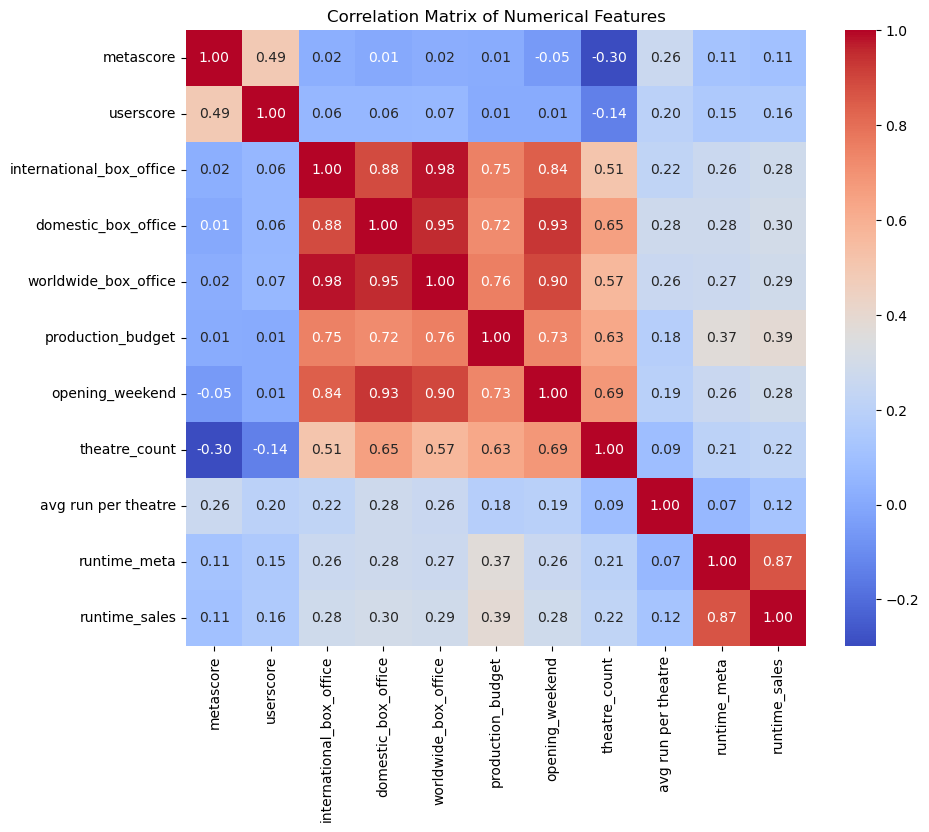

In [24]:
# Correlation matrix
corr = df_genre_encoded[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

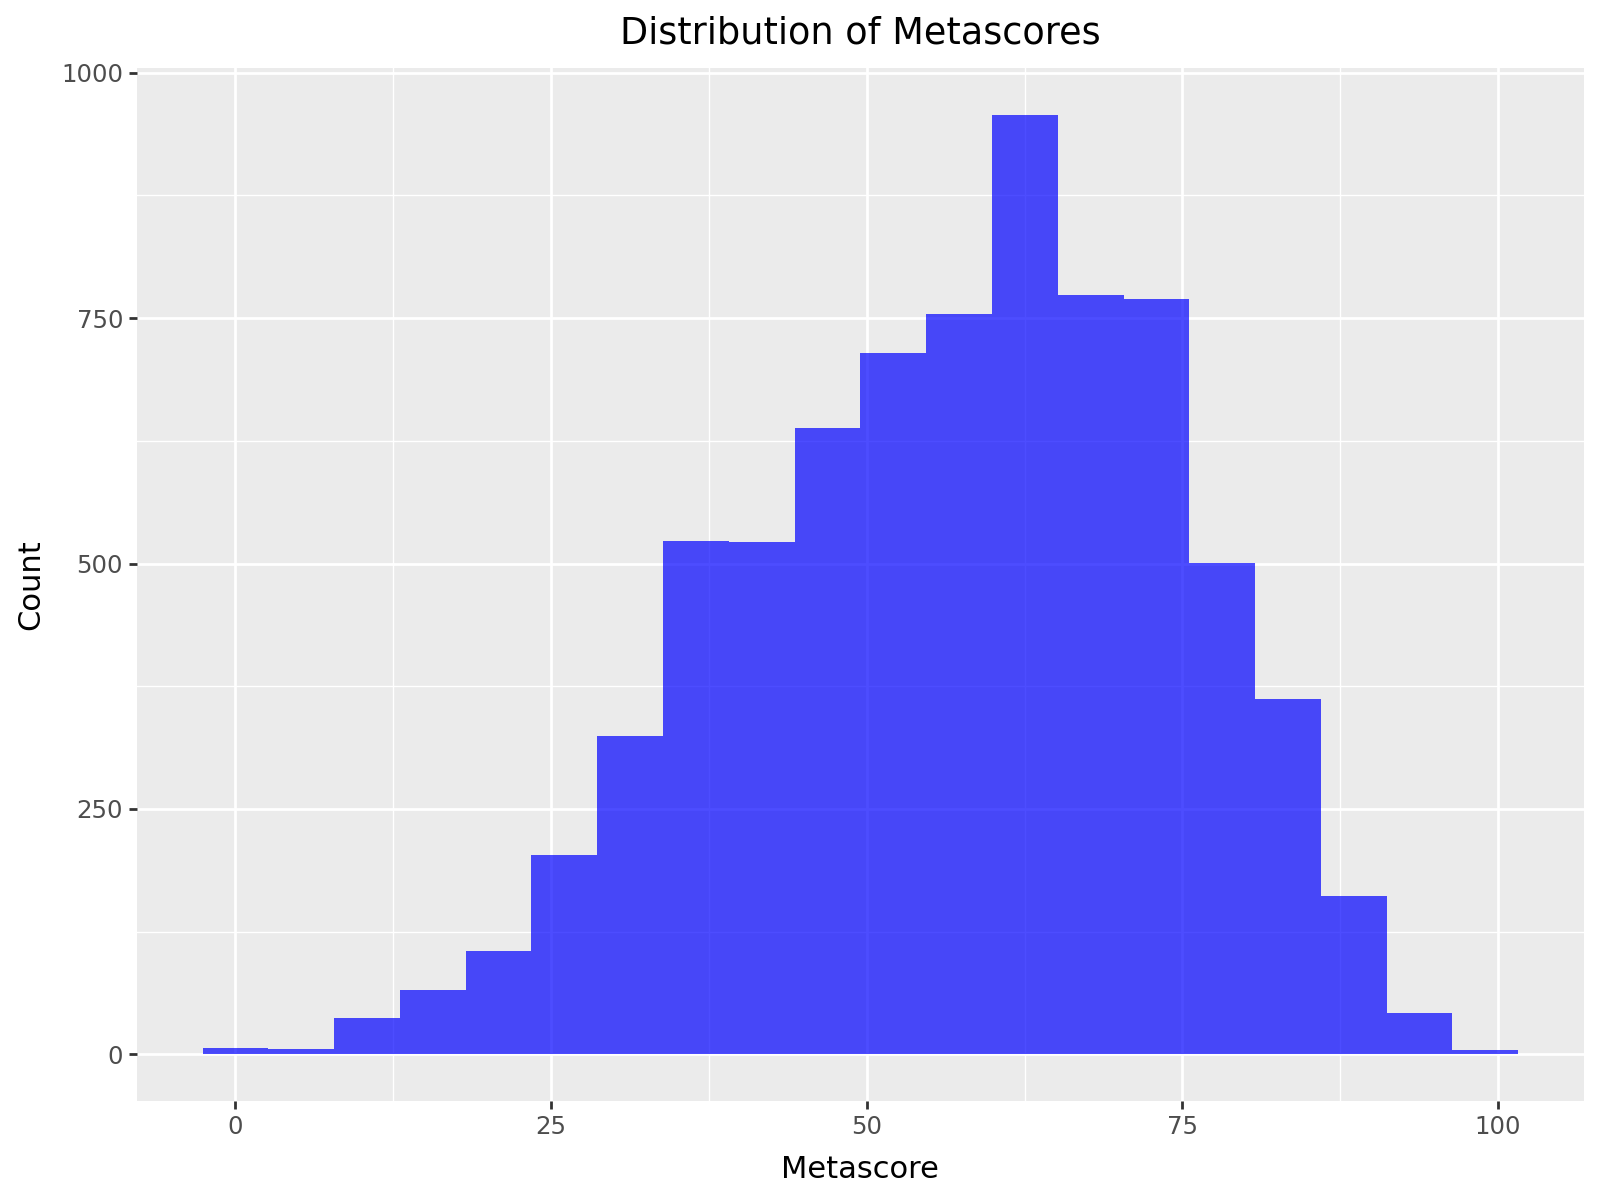

In [25]:
# Visualizations with plotnine

# Histogram of Metascore
(
    ggplot(df_genre_encoded, aes(x='metascore'))
    + geom_histogram(bins=20, fill='blue', alpha=0.7)
    + labs(title='Distribution of Metascores', x='Metascore', y='Count')
    + theme(figure_size=(8, 6))
)


c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_density : Removed 669 rows containing non-finite values.


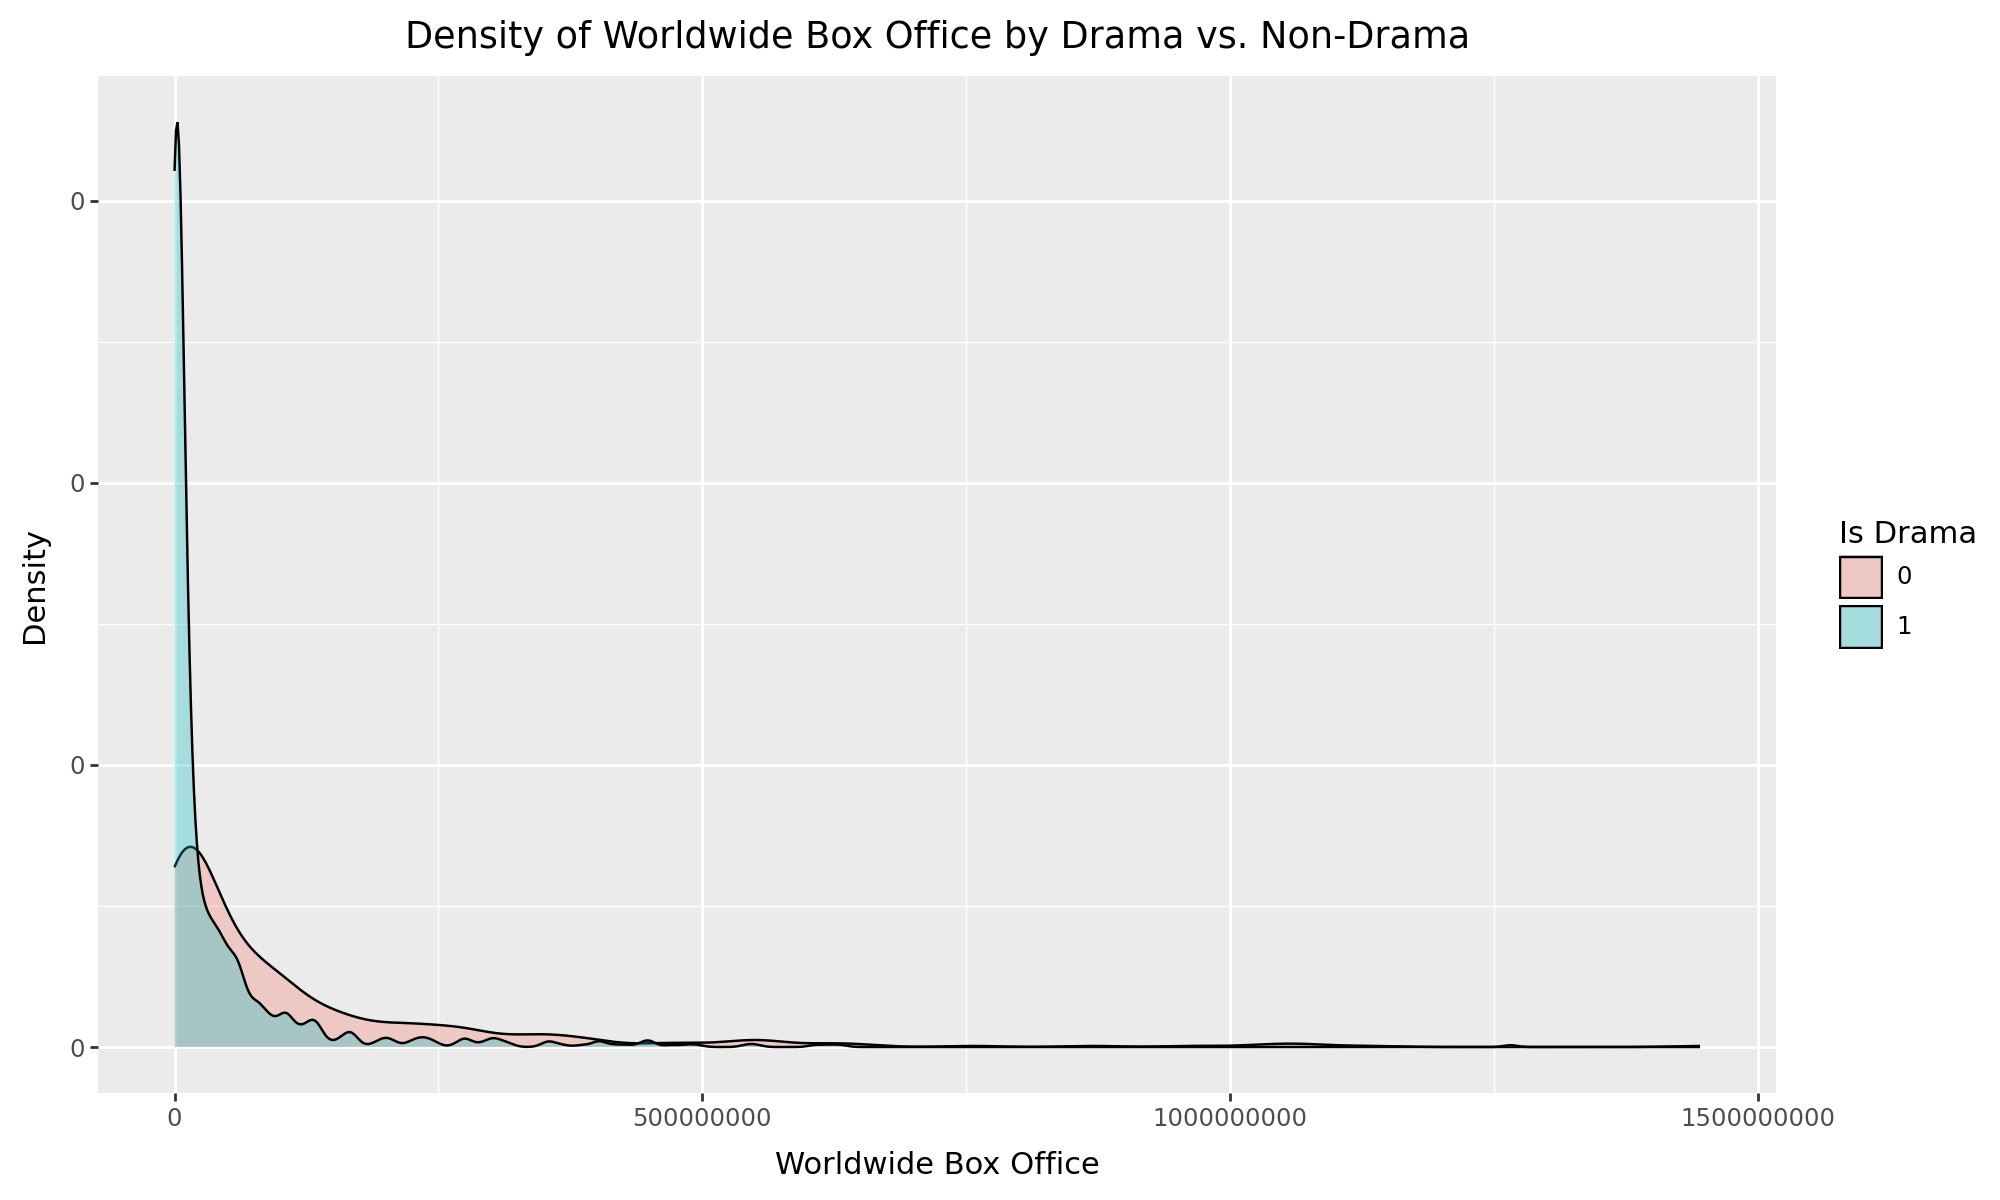

In [26]:
# Density plot of Worldwide Box Office by top genres (sample for drama and comedy)
df_sample = pd.concat([df_genre_encoded[df_genre_encoded['genre_drama'] == 1].sample(1000), df_genre_encoded[df_genre_encoded['genre_comedy'] == 1].sample(1000)])
(
    ggplot(df_sample, aes(x='worldwide_box_office', fill='factor(genre_drama)'))
    + geom_density(alpha=0.3)
    + labs(title='Density of Worldwide Box Office by Drama vs. Non-Drama', x='Worldwide Box Office', y='Density', fill='Is Drama')
    + theme(figure_size=(10, 6))
)

c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 4540 rows containing non-finite values.


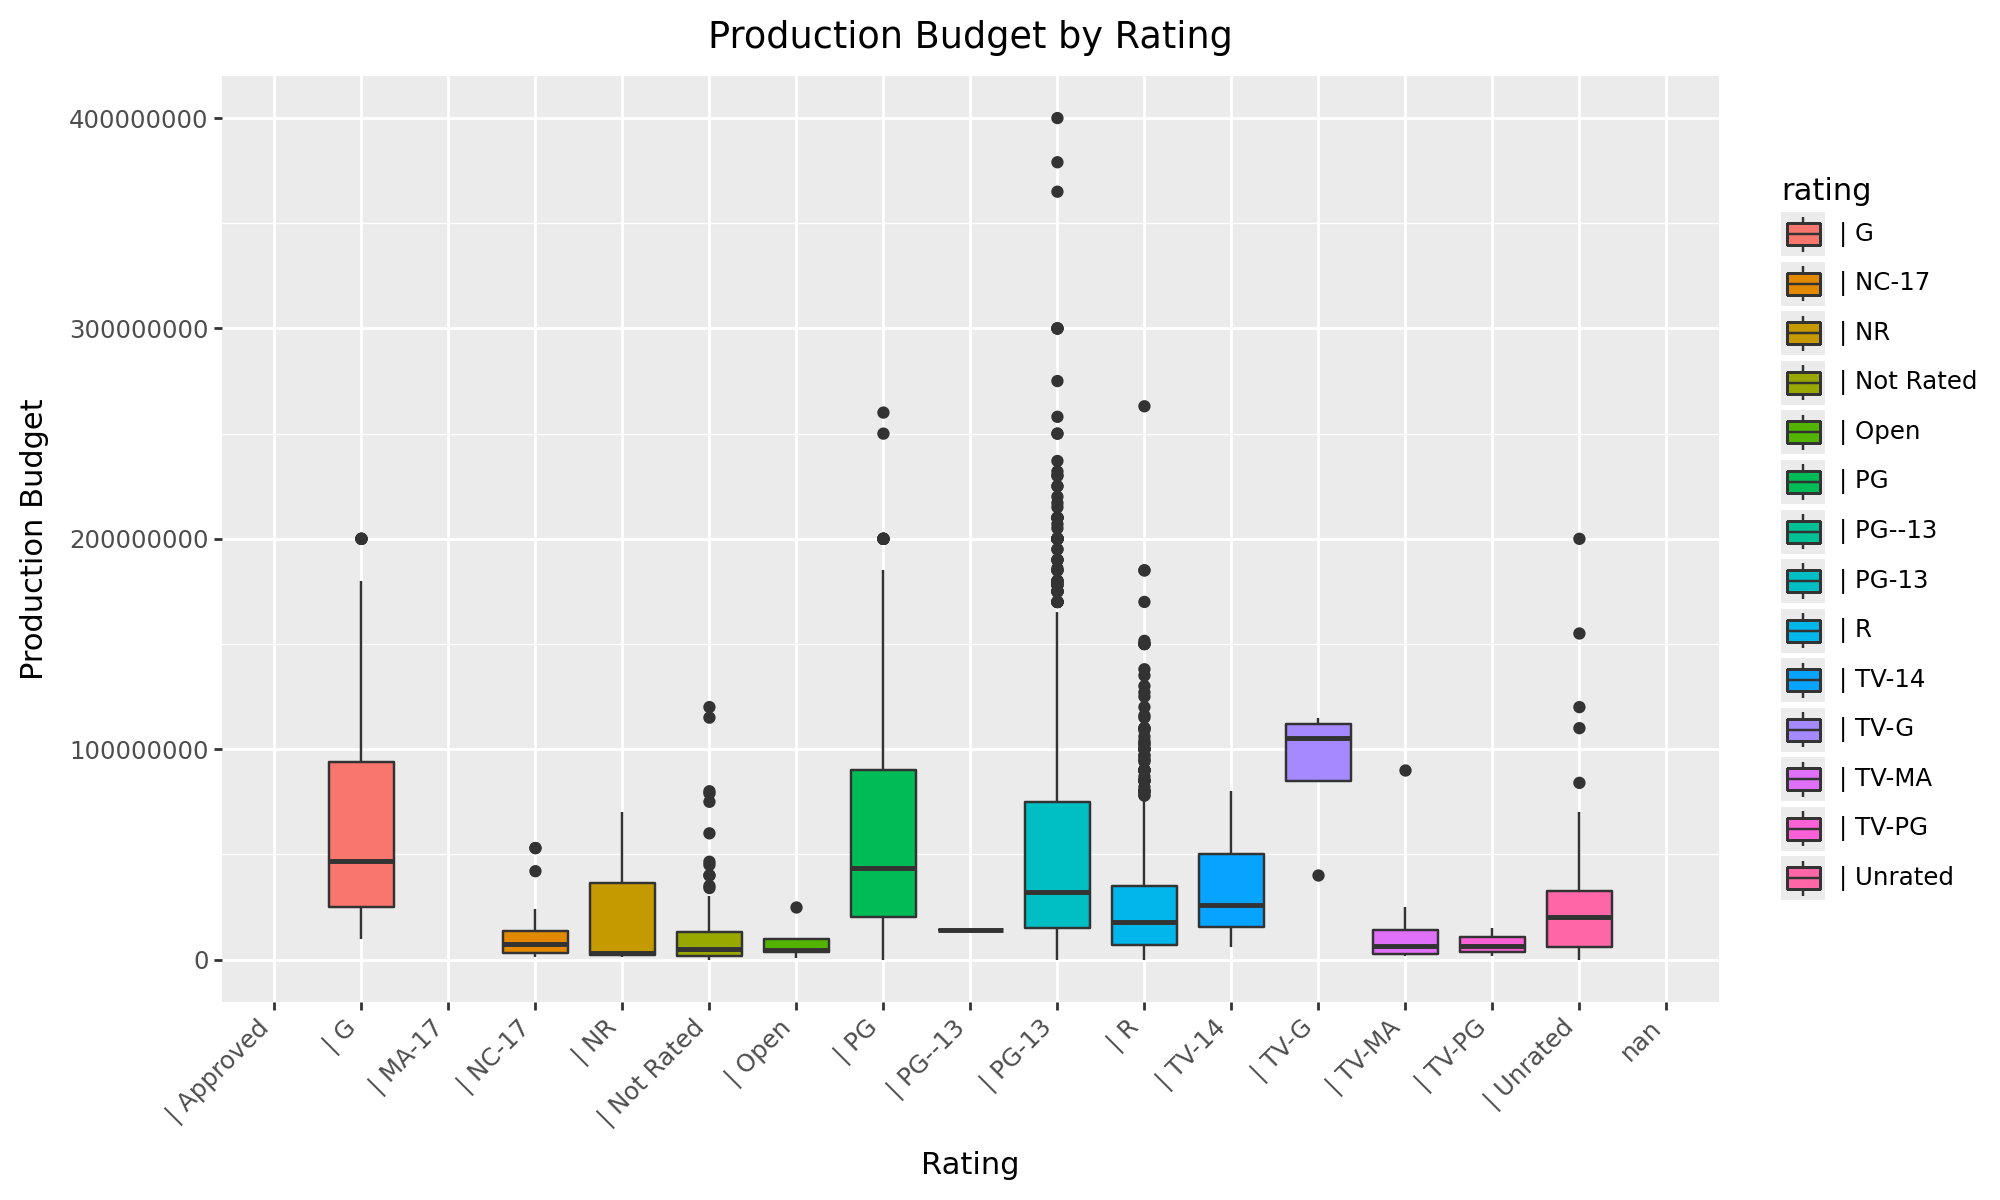

In [27]:
# Boxplot of Production Budget by Rating
(
    ggplot(df_genre_encoded, aes(x='rating', y='production_budget', fill='rating'))
    + geom_boxplot()
    + labs(title='Production Budget by Rating', x='Rating', y='Production Budget')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(figure_size=(10, 6))
)

c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\plotnine\stats\stat_density.py:179: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\plotnine\stats\stat_density.py:184: PlotnineWarning: Groups with fewer than 2 data points have been removed.


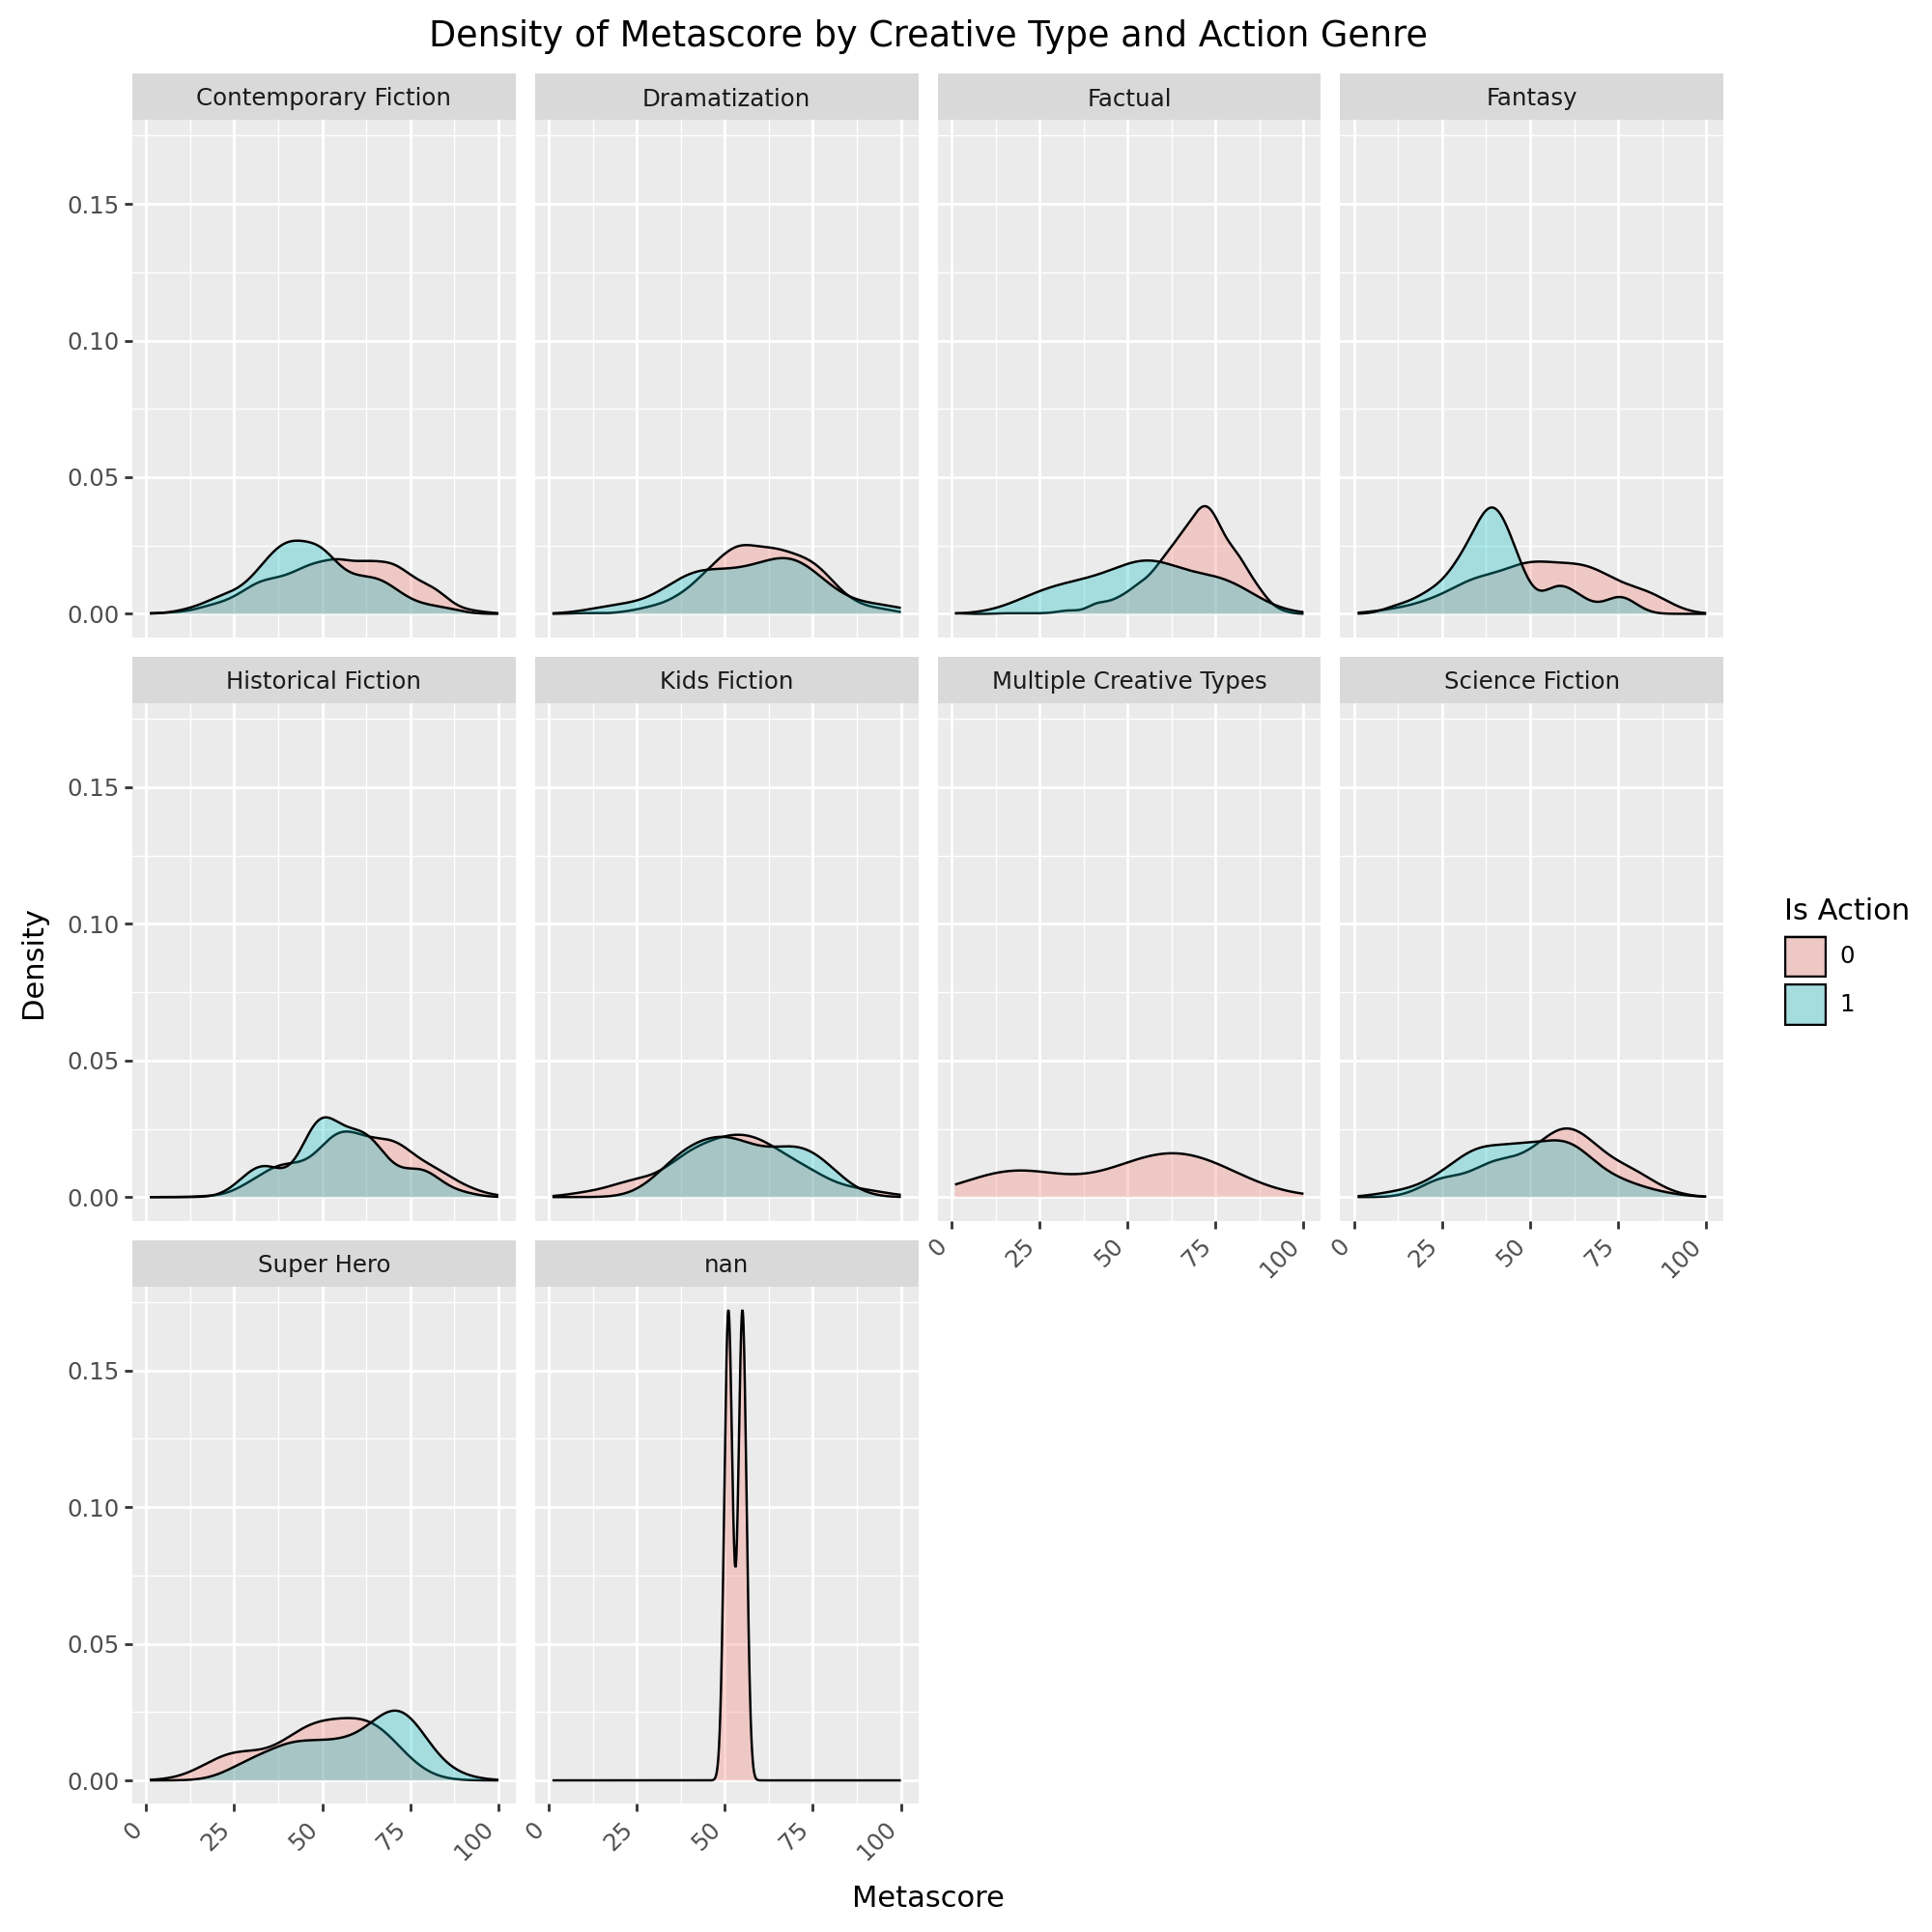

In [28]:
# Facet wrap: Density of Metascore by Creative Type
(
    ggplot(df_genre_encoded.sample(5000), aes(x='metascore', fill='factor(genre_action)'))
    + geom_density(alpha=0.3)
    + facet_wrap('~ creative_type')
    + labs(title='Density of Metascore by Creative Type and Action Genre', x='Metascore', y='Density', fill='Is Action')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(figure_size=(10, 10))
)

In [42]:
clean_df = df_genre_encoded
#Calculate ROI


# Create a new dataframe with only valid budgets
roi_df = clean_df.dropna(subset=['production_budget'])

# Verify it worked
print(f"Original rows: {len(clean_df)}")
print(f"Rows with budget: {len(roi_df)}")
print('\n')
print(roi_df[['cleaned_title', 'production_budget', 'roi']].head())

# Keep rows where budget exists AND is greater than 0
roi_df = clean_df[clean_df['production_budget'] > 0]

# Now check your top performers
print ('\n-------------TOP PERFORMERS------------------')
print(roi_df[['cleaned_title', 'roi']].sort_values(by='roi', ascending=False).head())

Original rows: 7467
Rows with budget: 2978


          cleaned_title  production_budget       roi
1   10 cloverfield lane         15000000.0  6.219095
7        102 dalmatians         85000000.0 -0.212452
12            12 rounds         20000000.0 -0.134668
13            12 strong         35000000.0  1.031954
14     12 years a slave         20000000.0  8.038253

-------------TOP PERFORMERS------------------
            cleaned_title         roi
5217  paranormal activity  430.517853
6544        super size me  341.058585
4781    my date with drew  163.582727
5076                 once  153.341847
5452               primer  119.275143


In [43]:
# Step 5: Derive budget_level
def categorize_budget(budget):
    if budget < 10000000:
        return 'Low'
    elif budget <= 50000000:
        return 'Medium'
    else:
        return 'High'

clean_df['budget_level'] = clean_df['production_budget'].apply(categorize_budget)

In [44]:
# Step 6: Parse release_date for month, quarter, season
# Handle various date formats; assume 'release_date' is string like 'January 1st' or '2002 (Wide) by'
clean_df['release_date'] = clean_df['release_date'].astype(str)  # Ensure string
clean_df['full_date'] = clean_df.apply(lambda row: f"{row['release_date']} {row['year']}" if str(row['year']) != 'nan' else row['release_date'], axis=1)

# Parse dates (this may need adjustment based on exact formats in data)
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

clean_df['parsed_date'] = clean_df['full_date'].apply(parse_date)
clean_df = clean_df.dropna(subset=['parsed_date'])  # Drop invalid dates

clean_df['month'] = clean_df['parsed_date'].dt.month
clean_df['quarter'] = clean_df['parsed_date'].dt.quarter

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

clean_df['season'] = clean_df['month'].apply(get_season)
print(clean_df.season)

0       Summer
1       Spring
2         Fall
3       Summer
4       Winter
         ...  
7671      Fall
7672    Summer
7673      Fall
7674    Summer
7675    Spring
Name: season, Length: 7461, dtype: object


C:\Users\arian\AppData\Local\Temp\ipykernel_33428\2535022048.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\arian\AppData\Local\Temp\ipykernel_33428\2535022048.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\arian\AppData\Local\Temp\ipykernel_33428\2535022048.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [46]:
# 1. Identify all your genre columns
genre_cols = [col for col in clean_df.columns if col.startswith('genre_')]

# 2. Create a list to store the results
results = []

for genre in genre_cols:
    # Filter rows where this specific genre is 1 (True)
    genre_data = clean_df[clean_df[genre] == 1]
    
    # Calculate stats for this genre
    # Use 'total_revenue' if you created it in the previous step, otherwise use 'worldwide_box_office'
    stats = genre_data['worldwide_box_office'].agg(['mean', 'median', 'count'])
    
    # Add the genre name (stripping 'genre_' for cleanliness)
    stats['genre'] = genre.replace('genre_', '')
    results.append(stats)

# 3. Convert list of series to a DataFrame
genre_stats = pd.DataFrame(results).set_index('genre')

# 4. Sort and print
genre_stats = genre_stats.sort_values('mean', ascending=False)

print("\nSub-question 1: Genre Influence on Revenue")
print(genre_stats)


Sub-question 1: Genre Influence on Revenue
                     mean       median   count
genre                                         
adult        2.857904e+08  285790362.5     2.0
animation    2.677157e+08  144003749.0   213.0
adventure    2.643076e+08  116790466.5   658.0
fantasy      2.411194e+08   96096018.0   441.0
sci-fi       2.254849e+08   81150788.0   433.0
family       2.101110e+08   93394462.0   411.0
action       1.931916e+08   76178302.0   884.0
musical      1.607991e+08   44580648.5    96.0
comedy       8.911338e+07   24768045.5  1570.0
thriller     8.814281e+07   21423683.0  1338.0
mystery      8.525128e+07   23549031.0   445.0
crime        6.970026e+07   21741985.5   708.0
war          6.955565e+07   11229035.0   173.0
romance      6.515651e+07   16602270.0   832.0
horror       5.831880e+07   16873925.0   469.0
sport        5.056870e+07   25792421.0   142.0
western      4.740540e+07    6371899.0    43.0
history      4.657884e+07    9263940.0   221.0
drama        4.2

In [47]:
# 1. Identify genre columns
genre_cols = [col for col in clean_df.columns if col.startswith('genre_')]

# 2. Lists to store the results
roi_results = []
revenue_results = []

for genre_col in genre_cols:
    # Get the simple name (e.g., "Action" instead of "genre_Action")
    genre_name = genre_col.replace('genre_', '')
    
    # Filter for movies that belong to this genre
    genre_data = clean_df[clean_df[genre_col] == 1]
    
    # --- ROI Analysis ---
    # Group by budget_level for this specific genre
    roi_stats = genre_data.groupby('budget_level')['roi'].agg(['mean', 'count'])
    roi_stats['genre'] = genre_name  # Add genre name to keep track
    roi_results.append(roi_stats)
    
    # --- Revenue Analysis ---
    rev_stats = genre_data.groupby('budget_level')['worldwide_box_office'].agg(['mean', 'count'])
    rev_stats['genre'] = genre_name
    revenue_results.append(rev_stats)

# 3. Combine all results into single DataFrames
budget_genre_roi = pd.concat(roi_results).reset_index().set_index(['genre', 'budget_level']).sort_values('mean', ascending=False)
budget_genre_revenue = pd.concat(revenue_results).reset_index().set_index(['genre', 'budget_level']).sort_values('mean', ascending=False)

# 4. Print results
print("\nSub-question 2: Budget Level and ROI by Genre")
print("ROI Stats (Top 10):")
print(budget_genre_roi.head(10))

print("\nRevenue Stats (Top 10):")
print(budget_genre_revenue.head(10))


Sub-question 2: Budget Level and ROI by Genre
ROI Stats (Top 10):
                               mean  count
genre       budget_level                  
adult       Medium        13.269874      1
horror      Low           13.231884    118
animation   Low           12.150785     10
documentary Low           10.271492     64
thriller    Low            8.426851    207
sci-fi      Low            8.425856     38
music       Low            8.159283     37
fantasy     Low            8.084088     29
family      Low            7.628493     21
mystery     Low            7.516506     71

Revenue Stats (Top 10):
                                mean  count
genre     budget_level                     
adult     Medium        5.707950e+08      1
adventure High          3.379150e+08    481
animation High          3.306869e+08    161
sci-fi    High          3.110675e+08    286
fantasy   High          3.055456e+08    320
family    High          2.817787e+08    268
action    High          2.685128e+08    

In [48]:
# Step 9: Analysis for Sub-question 3 - Timing Effect
season_stats = clean_df.groupby('season')['worldwide_box_office'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
month_stats = clean_df.groupby('month')['worldwide_box_office'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nSub-question 3: Timing Impact on Revenue")
print("By Season:")
print(season_stats)
print("By Month:")
print(month_stats)


Sub-question 3: Timing Impact on Revenue
By Season:
                mean      median  count
season                                 
Summer  8.426381e+07   6447222.5   1202
Spring  7.628695e+07   8200127.0   1211
Winter  7.453428e+07  22099706.0    995
Fall    6.256499e+07   9187575.0   1381
By Month:
               mean  count
month                     
6      1.139286e+08    387
5      1.087420e+08    378
11     1.064423e+08    422
12     1.037412e+08    413
7      1.010766e+08    378
3      6.838267e+07    436
2      6.038273e+07    323
4      5.406592e+07    397
10     4.788496e+07    504
1      4.560953e+07    259
8      4.345028e+07    437
9      3.813098e+07    455
